# DHS Data Compression and Extraction


Load data and necessary libraries 

In [1]:
% matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import IOFunctions as iof
import os 
import pprint as pp
import pandas as pd
import cv2
import pickle
import configparser
import tempfile
import boto3

Use some of the code we used before to extract PCA compressed versions of the data.

* Load 10% resized dataset
* Examine cumulative distribution of data and determine threshold
* After determining threshold, clear noise
* After clearing noise, normalize data, excluding the background.

In [140]:
#Now, let's apply these duntions to the entire dataset and plot the distribution again.
#We want to normalize over the entire dataset, so that we may be able to handle duds, or samples with no subject in them.
NOISE_THRESHOLD = 7000
def NormalizeImage(x,average,std):
    return (x-average)/std

def ExtractNormParameters(x):
    mask = x > NOISE_THRESHOLD
    average = np.average(x,weights = mask)
    std = x[mask].std()
    return average,std

def ReduceNoise(x):
    if x < NOISE_THRESHOLD:
        x = NOISE_THRESHOLD
    return x

def ReduceNoiseandNormalize(x,average,std):
    if x < NOISE_THRESHOLD:
        x = NOISE_THRESHOLD
    return (x-average)/std

def CleanData(x):
    ReduceNoise_v = np.vectorize(ReduceNoise)
    average, std = ExtractNormParameters(x)
    for s in range(x.shape[0]):
        for a in range(x.shape[3]):
            x[s,:,:,a] = ReduceNoise_v(x[s,:,:,a])
            x[s,:,:,a] = NormalizeImage(x[s,:,:,a],average,std)
    return average, std


In [28]:

#Helper functions
def GetShuffledKeys(bucket):
    contents = [k.key for k in bucket.objects.all()]
    contents = contents[1:]
    np.random.shuffle(contents) #Remove initial empty key in the result set
    return contents

def GetAWSCredentials():
    '''
    Get AWS credentials from config file.
    
    '''
    config = configparser.ConfigParser()
    config.read('S3.conf')
    AWS_ACCESS_KEY_ID = config['DEFAULT']['AccessKeyId']
    AWS_SECRET_ACCESS_KEY = config['DEFAULT']['AccessKeySecret']
    return AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY

def GetAWSClient(key_id,secret_access_key):
    '''
    Connect to S3 client. 
    
    '''
    client = boto3.resource('s3',aws_access_key_id = key_id ,
                      aws_secret_access_key= secret_access_key)
    return client
    
def GetLabelsDict(labels_dir):
    '''
    Reads csv with label data and organizes it into a dict with the image id's as keys
    and arrays of probabilities for the different zones as values.
    
    '''
    labels = pd.read_csv(labels_dir)
    labels = [[i,j] for i,j in zip(labels['Id'],labels['Probability'])] 
    labels_merged = iof.merge_17(labels) #Returns list of ids and corresponding list of zones
    labels_dict = {i:j for i,j in labels_merged}
    return labels_dict


        



class BatchRequester:
    '''
    Class used to request batches from AWS server.
    
    '''
    keys = None
    num_retrievals = 0
    key_pointer = 0
    batch_size = None
    bucket = None
    temp = None
    labels_dict = None
    extension = None
    zones = 0
    dim = []
    no_label_ary =[]
    failed_ary = []
    
    class CustomException(Exception):
        '''
        Custom Exception class
    
        '''
        def __init__(self, value):
            self.parameter = value
        def __str__(self):
            return repr(self.parameter)
    
    def __init__(self,bucket,key_ary,labels_dict,dataDir,
                 temp_dir,extension,batch_size=10,zones=17,dim=[512,660,64]):
        self.bucket = bucket
        self.keys = key_ary.copy()
        self.batch_size = batch_size
        self.temp_dir = temp_dir
        self.labels_dict = labels_dict.copy()
        self.dataDir = dataDir
        self.extension = extension    
        self.zones = zones
        self.dim = dim
    
    def DoItemsRemain(self):
        '''
        Checks to see whether any unexamined keys remain.
        
        '''
        if self.key_pointer < len(self.keys):
            return True
        else:
            return False
    
    def AttemptLabelRetrieval(self,key):
        '''
        Attempts to retrieve label data using key from dictinary passed to 
        the BatchRequester
        
        '''
        
        img_id = key.strip().replace(self.dataDir,'').replace(self.extension,'')
        try:
            label = np.array(self.labels_dict[img_id])
        except(KeyError):
            print("{} is not in the labeled data!".format(img_id))
            self.no_label_ary.append(img_id)
            raise self.CustomException("Label not found!")
        return label
        
    def AttemptDataRetrieval(self,key):
        '''
        Attempts to retrieve data from specified bucket using key.
        
        '''
        #DataException = self.CustomException("Failed data retrieval!")
        
        img_id = key.strip().replace(self.dataDir,'').replace(self.extension,'')
        filename = "{}.{}".format(img_id,self.extension)
        path = os.path.join(self.temp_dir,filename)
        failure = False
        with open(path,"w+b") as f:
            self.bucket.download_fileobj(key,f)
            try:
                img_array = iof.read_data(path)
            except:
                print("Something went wrong. Skipping {}".format(img_id))
                self.failed_ary.append(img_id)
                failure = True
        os.remove(path)
        if failure:
            raise self.CustomException("Data could ot be retrieved.")
        else:
            return img_array
    def NextBatch(self,size=None):
        '''
        Gets a batch of data of the specified size.  If no more images remain,
        then it returns a batch of smaller size.
        
        '''
        #angles = [0,8,16,24,32,40,48,56]
        #new_dim = 500
        #new_dim2 = 600
        
        if not self.DoItemsRemain():
            return None,None
        
        if not size:
            size = self.batch_size     
        
        i = 0
        batch_data = np.zeros((size,self.dim[0],self.dim[1],self.dim[2]))
        #batch_data = np.zeros((size,new_dim,new_dim2,self.dim[2]))
        batch_labels = np.zeros((size,self.zones))
        
        while i < size and self.DoItemsRemain():
            try:
                batch_labels[i,:] = self.AttemptLabelRetrieval(self.keys[self.key_pointer])
            except(self.CustomException):
                self.key_pointer += 1
                continue
            try:
                batch_data[i,:,:,:] = self.AttemptDataRetrieval(self.keys[self.key_pointer])
                #batch_data[i,:,:,:] = cv2.resize(self.AttemptDataRetrieval(self.keys[self.key_pointer]),
                 #                                dsize=(new_dim2,new_dim))
            except(self.CustomException):
                self.key_pointer += 1
                continue
            i += 1
            self.key_pointer += 1
        
        if i == size:
            return batch_data, batch_labels        
        else:
            return batch_data[:i,:,:,:],batch_labels[:i]
            
 
    

We need to crop the images and then reshape them so that they are uniform for a neural net. 

In [29]:
to_directory = 'DHSData_clean/'
#AWS and Directory information 
bucketName = 'miscdatastorage'
dataDir = 'DHSData/'
temp_dir = 'temp'
labels_dir = r'stage1_labels.csv'
#Connect to AWS
key_id, secret_key = GetAWSCredentials()
client = GetAWSClient(key_id,secret_key)
bucket = client.Bucket(bucketName)
#Initialize required parameters
key_ary = GetShuffledKeys(bucket)
labels_dict = GetLabelsDict(labels_dir)
extension = '.a3daps'

requester = BatchRequester(bucket,key_ary,labels_dict,dataDir,temp_dir,extension)

#Grab a sample of 20 scans.

X,y = requester.NextBatch(20)


249092cc1775fabcb79ba439ba974759 is not in the labeled data!
c49a9aaa0c748cc5a4e88b30504a7732 is not in the labeled data!
104e284349ffe68378745fc8c5638eab is not in the labeled data!
92447e0dccf16de23066830b85ef1445 is not in the labeled data!
Something went wrong. Skipping 47e2a4a8e13ec7100f6af8cd839d1bb3
d9b6081197ee70ebcaeabc8bf7749792 is not in the labeled data!


In [30]:
print(X.shape)
print(y.shape)

(20, 512, 660, 64)
(20, 17)


Now, how should we crop? 
* Find the first row and column above the noise threshold and mark those as the boundaries for the cropped image
* Resize those images to standard dimensions

What should the dimensions be?
* Minimize distortion of the images (they should be close to the average dimensions of the cropped images before resizing).

Crop images and plot the distirbution of each dimension.  Here, we will treat the image from each angle as its own image. We should, however, makes sure there is no significant variation between samples. 

Raw function returned 147,401,609:
Clean function returned 147,401,609:


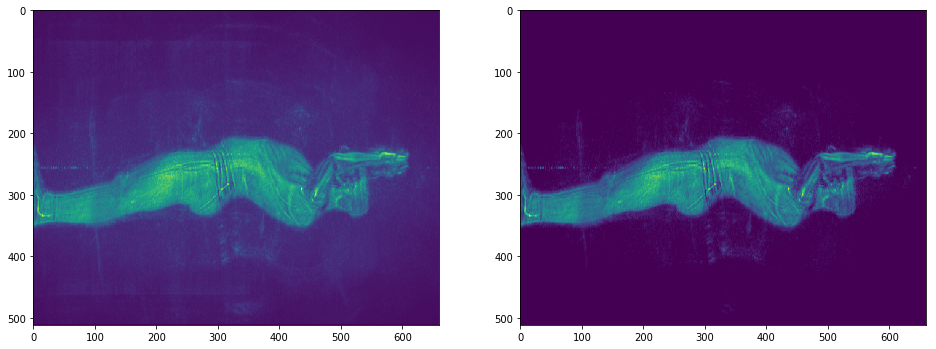

In [124]:
def FindCropDimensions(x,thresh=NOISE_THRESHOLD):
    ''' Expects a 2d image ndarray. Returns the minimum row and column along each dimension
    with a value greater than the noise threshold.'''
    min_i = x.shape[0]-1
    max_i = 0 
    max_j = 0
    RELEVANT_THRESHOLD = .50
    CONSEC_THRESHOLD = 35
    #Loop through columns
    for j in range(x.shape[1]):
        num_relevant = 0
        max_consec = 0
        num_consec = 0
        for i in range(x.shape[0]):
            if x[i,j] > thresh:
                num_relevant += 1
                num_consec += 1
            else:
                if num_consec > max_consec:
                    max_consec = num_consec
                num_consec = 0
        if j > max_j and (num_relevant/x.shape[0] > RELEVANT_THRESHOLD or max_consec > CONSEC_THRESHOLD):
            max_j = j
    #Loop through rows        
    for i in range(x.shape[0]):
        num_relevant = 0
        max_consec = 0
        num_consec = 0
        for j in range(x.shape[1]):
            if x[i,j] > thresh:
                num_relevant += 1
                num_consec += 1
            else:
                if num_consec > max_consec:
                    max_consec = num_consec
                num_consec = 0
        if i > max_i and (num_relevant/x.shape[1] > RELEVANT_THRESHOLD or max_consec > CONSEC_THRESHOLD):
            max_i = i
        if i < min_i and (num_relevant/x.shape[1] > RELEVANT_THRESHOLD or max_consec > CONSEC_THRESHOLD):
            min_i = i
    
    if min_i > max_i:#Image with no signal
        temp = min_i
        min_i = max_i
        max_i = temp
    
    return min_i,max_i,max_j

#Load stats
with open('stats.pickle',"rb") as f:
    stats = pickle.load(f)
    average = stats['average']
    std = stats['std']
    
#Run test
sample = 14
angle = 16
sample_image = np.copy(X[sample,:,:,angle])
ReduceNoise_v = np.vectorize(ReduceNoise)
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#Raw
i_min,i_max,j_max = FindCropDimensions(sample_image)
ax.imshow(sample_image, cmap = 'viridis')

#Clean
sample_image = ReduceNoise_v(sample_image)
i_cmin,i_cmax,j_cmax = FindCropDimensions(sample_image)
ax2.imshow(sample_image, cmap = 'viridis')

#Output
print("Raw function returned {},{},{}:".format(i_min,i_max,j_max))
print("Clean function returned {},{},{}:".format(i_cmin,i_cmax,j_cmax))
           


The image above shows that we can save some processing time by cropping before cleaning. The results of our function are the same whether before or after cleaning. 

Now, let's look at the distribution of dimensions we get from these images. 

In [105]:
#Gather stats
min_i_ary = []
max_i_ary = []
max_j_ary = []
sample_ary = []
angle_ary = []

for s in range(X.shape[0]):
    for a in range(X.shape[3]):
        min_i,max_i,max_j = FindCropDimensions(X[s,:,:,a])
        min_i_ary.append(min_i)
        max_i_ary.append(max_i)
        max_j_ary.append(max_j)
        sample_ary.append(s)
        angle_ary.append(a)

df = pd.DataFrame({'Min_i':min_i_ary,'Max_i':max_i_ary,'Max_j':max_j_ary,
                  'Sample_n':sample_ary,'Angle_n':angle_ary})
     


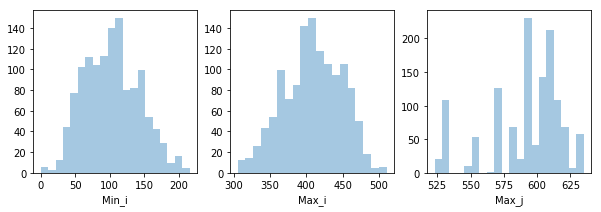

In [106]:
#Plot output
fig,axes = plt.subplots(nrows=1,ncols=3,)
fig.set_size_inches(10,3,forward=True)
i = 0
for var in ['Min_i','Max_i','Max_j']:
    sns.distplot(df[var],kde=False,ax=axes[i])
    i += 1


From the above:
* We should check the distribution in widths
* Check images with Min_i near zero

In [107]:
#Images with min_i near zero
df_check = df[df['Min_i']<30].sort_values(by='Min_i')
df_check.head(12)

,Angle_n,Max_i,Max_j,Min_i,Sample_n
254,62,395,601,0,3
255,63,397,601,0,3
192,0,399,601,1,3
253,61,393,601,3,3
193,1,400,602,8,3
252,60,391,600,8,3
194,2,399,602,14,3
251,59,389,600,15,3
1277,61,426,606,20,19
1278,62,428,606,22,19


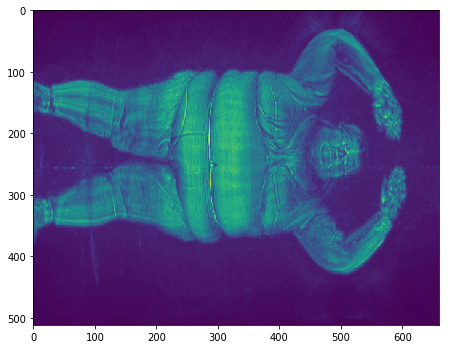

In [109]:
#Let's visualize the data above
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(121)
ax.imshow(X[19,:,:,62], cmap = 'viridis')

Min_i near zero seems to indicate that:
* The subject is off-center
* The subject is on the larger size

Now let's look at distribution of widths

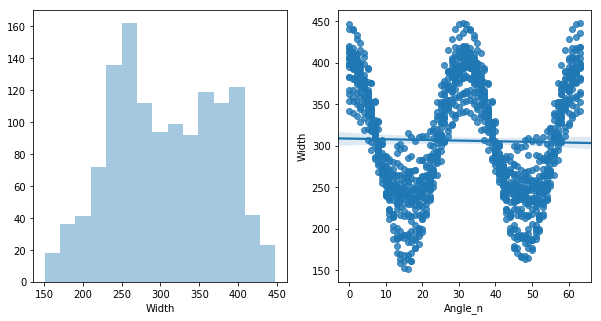

In [111]:
#Now, the distribution of widths
df['Width']= df['Max_i']-df['Min_i']

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(121)
sns.distplot(df['Width'],kde=False,ax=ax)

ax2 = fig.add_subplot(122)
sns.regplot("Angle_n","Width",data=df,ax=ax2)

It is somewhat concerning that when we crop "thin" images they will have to be blown up to a width closer to 500 pixels (a factor of 2) in order to make the sizes uniform.

Now, 
* Let's create the functions that will crop the images and resize them.
* Visualize the results for images at the extremes of dimension distributions.

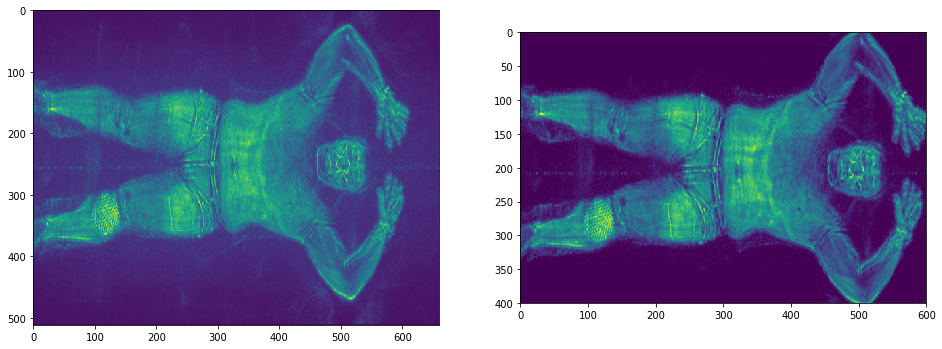

In [142]:
#Cropping and resizing functions
def CropImage(x,min_i,max_i,max_j,new_i,new_j):
    '''Returns regions of interest in the image'''
    resize_i = False
    resize_j = False
    
    #Width
    old_i = max_i-min_i
    #If crop is of smaller width than new_i
    if old_i <= new_i:
        diff = new_i-old_i
        buffer,remainder = divmod(diff,2)
        #Move min_i
        if min_i > buffer:
            min_i = min_i - buffer
        else:
            remainder += buffer - min_i
            min_i = 0
        max_i += buffer + remainder
    else:
        #Image needs to be resized along this dimension
        resize_i = True
    
    #Height
    old_j = max_j
    #If crop is of smaller height than new_j
    if old_j <= new_j:
        diff = new_j - old_j
        #Move max_j
        max_j += diff
    else:
        #Image needs to be resized
        resize_j = True
        
    #Resize along either dimension?
    if resize_i or resize_j:
        return cv2.resize(x[min_i:max_i,:max_j],dsize=(new_j,new_i))
    else:
        return x[min_i:max_i,:max_j]

def CropCleanResize(x,new_i,new_j):
    '''Crops and returns 2d image with specified uniform dimensions'''
    min_i,max_i,max_j = FindCropDimensions(x)
    x_new = CropImage(x,min_i,max_i,max_j,new_i,new_j)
    ReduceNoiseAndNormalize_v = np.vectorize(ReduceNoiseandNormalize)
    x_new = ReduceNoise_v(x_new)
    return x_new

fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

NEW_I = 400
NEW_J = 600

sample = 0
angle = 0
sample_image = X[sample,:,:,angle].copy()
ax.imshow(sample_image, cmap = 'viridis')

sample_image_new = CropCleanResize(sample_image,NEW_I,NEW_J)
ax2.imshow(sample_image_new, cmap = 'viridis')
    

In [149]:
#Visualize changes for images at the extremes
df[(df['Width'] < 175)].head(5)

,Angle_n,Max_i,Max_j,Min_i,Sample_n,Width
333,13,379,618,209,5,170
334,14,373,617,214,5,159
335,15,369,614,216,5,153
336,16,367,613,216,5,151
337,17,373,613,212,5,161


In [148]:
df[(df['Width'] > 400)].head(5)

,Angle_n,Max_i,Max_j,Min_i,Sample_n,Width
0,0,467,608,27,0,440
1,1,469,608,30,0,439
2,2,468,608,35,0,433
3,3,465,608,41,0,424
4,4,461,607,50,0,411


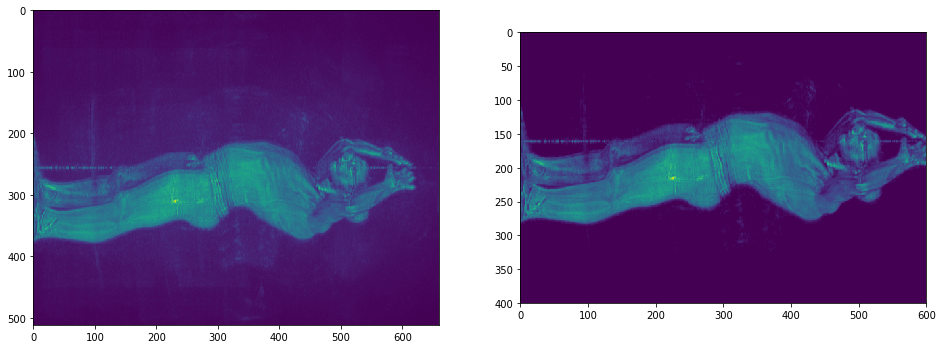

In [150]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

NEW_I = 400
NEW_J = 600

sample = 5
angle = 13
sample_image = X[sample,:,:,angle].copy()
ax.imshow(sample_image, cmap = 'viridis')

sample_image_new = CropCleanResize(sample_image,NEW_I,NEW_J)
ax2.imshow(sample_image_new, cmap = 'viridis')
    

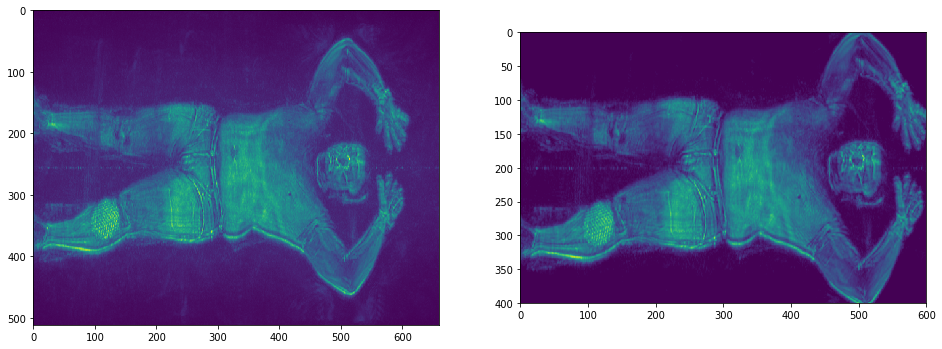

In [151]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

NEW_I = 400
NEW_J = 600

sample = 0
angle = 4
sample_image = X[sample,:,:,angle].copy()
ax.imshow(sample_image, cmap = 'viridis')

sample_image_new = CropCleanResize(sample_image,NEW_I,NEW_J)
ax2.imshow(sample_image_new, cmap = 'viridis')
    

Now we have cropped images of uniform sizes. Let's start thinking about what approach we would like to take to train a neural net. 
* We create a pipeline that crops and normalizes the images.
* How do we add angles to the data set?

Let's set up a gpu server and 
* run the data set on a simple CNN on each image individually.
* Assess performance by averaging scores
* Used pre-trained CNN coupled with LSTM's to run images sequentially and produce predictions. (Averaging results for now)
